# End-to-End Quantitative Investment Strategy
### *Implementing the Grinold-Kahn Framework for Active Portfolio Management*

**Author:** H. Naderi  
**Date:** January 2026  
**Repository:** [GitHub](https://github.com/naderih/Systematic-Asset-Pricing-Engine.git)

---

### **1. Executive Summary**
This notebook serves as the **orchestration dashboard** for the Systematic Asset Pricing Engine. It executes a full-stack quantitative research pipeline, transforming raw, point-in-time financial data into an optimized institutional portfolio. 

The strategy is built on the theoretical foundations of *Active Portfolio Management* (Grinold & Kahn), focusing on **idiosyncratic alpha extraction** while strictly controlling for systematic risk and transaction costs. The final output is a simulated track record validated by a rigorous backtesting engine.

### **2. System Architecture**
The logic is encapsulated in a custom Python library (`src`) designed for modularity and scale. This notebook orchestrates the following engines in sequence:

1.  **Risk Model (`risk.py`):**
    * **Methodology:** Fundamental Factor Model estimated via Fama-MacBeth regressions.
    * **Function:** Decomposes risk into Systematic ($XFX^T$) and Idiosyncratic ($\Delta$) components.
    * **Forecasting:** Uses EWMA (Half-Life = 36m) to predict the forward-looking Asset Covariance Matrix ($V$).

2.  **Alpha Engine (`alpha.py`):**
    * **Signal:** **Financial Constraints (Constraint Premium)**. We isolate the "Quality" factor by shorting distressed firms (high Whited-Wu index).
    * **Processing:** Performs **Gram-Schmidt Orthogonalization** to strip out market beta, ensuring the signal represents pure residual return ($h_B^T \alpha \approx 0$).
    * **Smoothing:** Applies a 3-month rolling average to reduce signal "flicker" and lower turnover.

3.  **Portfolio Optimizer (`portfolio.py`):**
    * **Objective:** Solves the unconstrained Mean-Variance problem ($h_{PA}^* \propto V^{-1} \alpha$) to maximize the Information Ratio.
    * **Constraints:** Applies **Ex-Post Scaling** for Volatility Targeting (10%) and Gross Leverage (3.0x).
    * **Execution:** Implements **Holdings Smoothing (0.5)** to minimize turnover and transaction costs.

4.  **Backtest Engine (`backtest.py`):**
    * **Simulation:** Replays history using strict **Point-in-Time** data (Lag Enforcement) to prevent lookahead bias.
    * **Attribution:** Calculates institutional metrics including Active Return, Information Ratio, and Risk-Adjusted Sharpe Ratio (net of $R_f$).

### System Initialization

In [5]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 

# --- CONFIGURATION ---
# Add 'src' to the python path to allow direct module imports
sys.path.append(os.path.abspath('src'))

# Define Data Directory (OneDrive Architecture)
onedrive_root = os.environ.get('OneDrive', '')
DATA_DIR = os.path.join(onedrive_root, '0. DATASETS', 'outputs')

# --- MODULE IMPORTS ---
# We import the four core engines defined in the System Architecture
from models.risk import RiskModel          # Step 1: Covariance Forecasting
from models.alpha import AlphaEngine       # Step 2: Signal Generation & Neutralization
from models.portfolio import PortfolioOptimizer # Step 3: Mean-Variance Optimization
from models.backtest import BacktestEngine # Step 4: Historical Simulation

print(f"System Initialized. Data Directory: {DATA_DIR}")

System Initialized. Data Directory: D:\OneDrive\0. DATASETS\outputs


### **Step 1: Dynamic Risk Modeling**
We begin by estimating the **Fundamental Factor Risk Model**.
* **Input:** Panel returns and factor exposures.
* **Process:** Fama-MacBeth regressions $\to$ EWMA Forecasting.
* **Output:** `factor_cov_matrices.parquet` (Systematic Risk) and `idio_vol.parquet` (Specific Risk).

### Execute Risk Engine

In [6]:
# 1. Initialize Engine
risk_model = RiskModel(DATA_DIR, half_life=36) # 3-Year Half-Life for EWMA

# 2. Load Data
risk_model.load_data()

# 3. Run Estimation (Fama-MacBeth)
risk_model.run_fama_macbeth()

# 4. Forecast Covariance (EWMA)
risk_model.predict_risk_matrices()

# 5. Save Outputs
risk_model.save_outputs()

Loading Data for Risk Model...
Data Loaded.
Running Fama-MacBeth Regressions...
Aligned Data: 1199061 rows found across 403 dates.
Fama-MacBeth Complete. Estimated 403 periods.
Forecasting Risk Matrices...
Risk forecasts complete.
Saving Risk Outputs...
Saved: D:\OneDrive\0. DATASETS\outputs\factor_cov_matrices.parquet
Saved: D:\OneDrive\0. DATASETS\outputs\idio_vol.parquet


### **Step 2: Alpha Signal Generation**
Next, we generate and purify the investment signals.
* **Signals:** Momentum (12-1m) and Financial Constraints (Whited-Wu).
* **Process:** The engine calculates raw scores, estimates dynamic betas, and performs **Gram-Schmidt Orthogonalization** to remove systematic market exposure.

Loading datasets...
Data loaded. Final shape: (1199061, 5)
Calculating rolling betas (this may take a moment)...
Beta calculation complete. Valid estimates: 701280 / 1199061
Winsorizing betas (1.0% - 99.0%)...
Neutralizing signal: Momentum...
Neutralizing signal: FinConstraint...
Finalizing signals...
Smoothing Alpha (3-month rolling average)...
Scaling signals to Unit Variance...

--- Verifying Signal Neutrality ---
Average Benchmark-Weighted Alpha Bias: -0.0013182110

Pipeline complete. Saved to: D:\OneDrive\0. DATASETS\outputs\alpha_signals.parquet

--- Alpha Signal Analysis ---


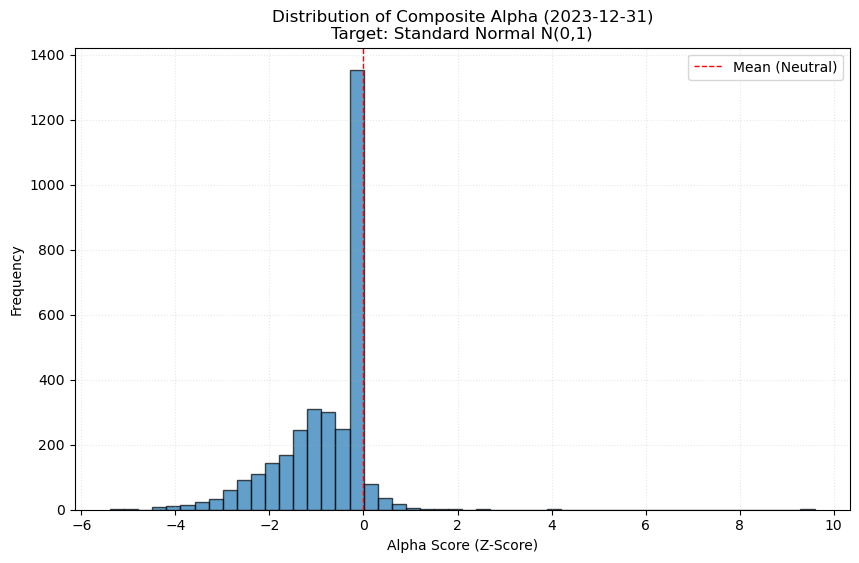

Mean: -0.7663 (Should be ~0.0)
Std:  0.9845  (Should be ~1.0)


In [7]:
# 1. Run the Engine
alpha_engine = AlphaEngine(DATA_DIR)
alpha_engine.run_pipeline()

# 2. Visualization: Inspect the Distribution of the Final Signal
print("\n--- Alpha Signal Analysis ---")
df_alpha = pd.read_parquet(os.path.join(DATA_DIR, 'alpha_signals.parquet'))

# Extract the latest cross-section for inspection
last_date = df_alpha.index.get_level_values('date').max()
latest_alphas = df_alpha.xs(last_date, level='date')['alpha_Composite_final']

# Plot Histogram
# We expect a Standard Normal distribution (Mean=0, Std=1)
plt.figure(figsize=(10, 6))
plt.hist(latest_alphas, bins=50, color='#1f77b4', edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=1, label='Mean (Neutral)')

plt.title(f"Distribution of Composite Alpha ({last_date.date()})\nTarget: Standard Normal N(0,1)")
plt.xlabel("Alpha Score (Z-Score)")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3, linestyle=':')
plt.show()

# Stats Check
print(f"Mean: {latest_alphas.mean():.4f} (Should be ~0.0)")
print(f"Std:  {latest_alphas.std():.4f}  (Should be ~1.0)")

### **Step 3: Portfolio Optimization**
We now construct the optimal portfolio.
* **Objective:** Maximize exposure to the **Financial Constraints** alpha while minimizing risk.
* **Signal:** `alpha_FinConstraint_final` (Shorting distressed stocks, Long stable stocks).
* **Configuration:**
    * **Target Risk:** 10% Annualized Tracking Error.
    * **Max Leverage:** 300% Gross Exposure.
    * **Turnover Smoothing:** 0.5 (Retaining 50% of positions to reduce churn).

### Execute Portfolio Optimizer

Loading Optimization Inputs (Signal: alpha_FinConstraint_final)...
Optimizing alpha_FinConstraint_final (Smoothing=0.5)...
Optimization Complete.

--- Active Risk Attribution ---


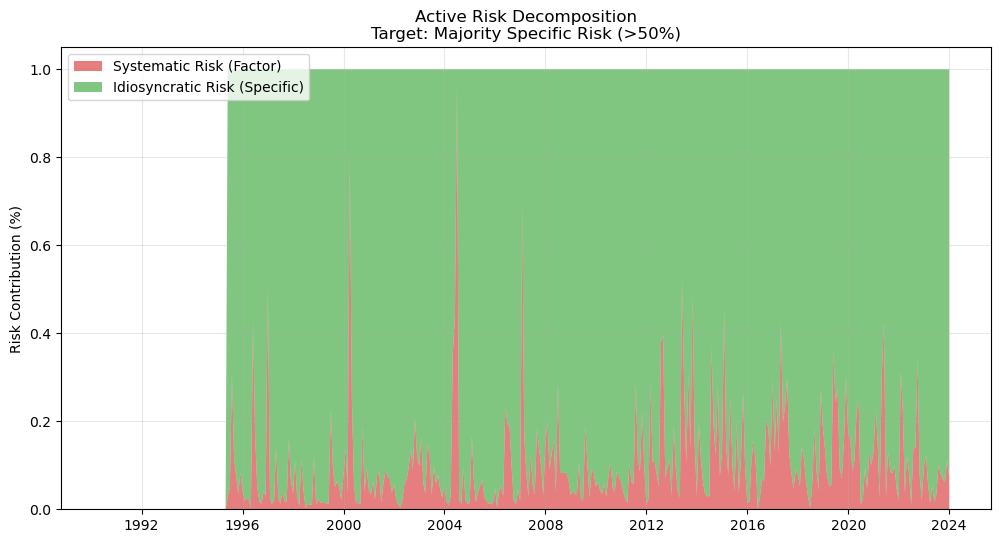

Average Specific Risk Ratio: 76.2%


In [ ]:
# 1. Initialize Optimizer
# We select 'alpha_FinConstraint_final' because research Buhlmaier and Whited (2018) shows it is a risk factor. 
# Also, this single factor outperformed the composite factor.
optimizer = PortfolioOptimizer(
    DATA_DIR, 
    alpha_col='alpha_FinConstraint_final', 
    target_active_risk=0.10, 
    max_leverage=3.0,
    turnover_smoothing=0.5  
)

# 2. Run Optimization
optimizer.run_optimization()

# 3. Visualization: Risk Attribution
print("\n--- Active Risk Attribution ---")
attr = pd.read_csv(os.path.join(DATA_DIR, 'risk_attribution.csv'), index_col=0, parse_dates=True)

# Plot Stacked Area Chart
plt.figure(figsize=(12, 6))
plt.stackplot(attr.index, 
              attr['factor_risk_pct'], 
              attr['specific_risk_pct'], 
              labels=['Systematic Risk (Factor)', 'Idiosyncratic Risk (Specific)'],
              colors=['#d62728', '#2ca02c'], alpha=0.6)

plt.title("Active Risk Decomposition\nTarget: Majority Specific Risk (>50%)")
plt.ylabel("Risk Contribution (%)")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

print(f"Average Specific Risk Ratio: {attr['specific_risk_pct'].mean():.1%}")

### **Step 4: Historical Backtest**
Finally, we validate the strategy by replaying the optimal holdings against history.
* **Process:** The engine enforces strict "Point-in-Time" lagging ($Holdings_t$ vs $Returns_{t+1}$).
* **Metrics:** We evaluate the **Sharpe Ratio** (Net of $R_f$) and **Information Ratio** (Active efficiency).

### Execute Backtest

Loading Backtest Data...


Core data loaded.
Fetching Fama-French Risk-Free Rate...
Risk-Free rate loaded successfully.
Running Backtest Simulation...
Applying Burn-in: Starting backtest from 1995-06-30...

      BACKTEST PERFORMANCE REPORT       
Annualized Return:     13.58%
Benchmark Return:      11.05%
Active Return:         2.52%
----------------------------------------
Portfolio Volatility:  17.10%
Tracking Error:        7.90%
----------------------------------------
Sharpe Ratio (Rf adj): 0.67
Information Ratio:     0.32
----------------------------------------
Max Drawdown:          -45.40%
Avg Monthly Turnover:  85.23%
Results saved to D:\OneDrive\0. DATASETS\outputs


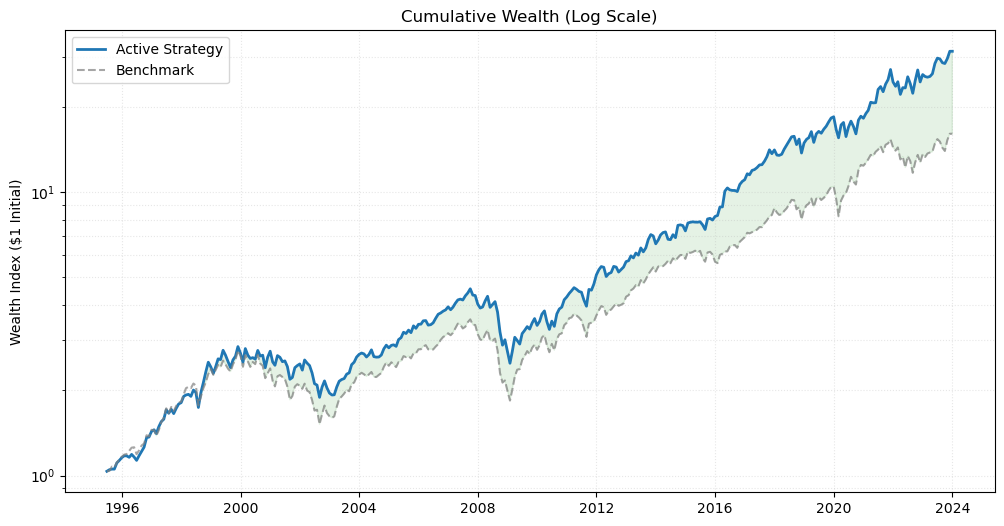

In [9]:
# 1. Initialize Backtester
bt = BacktestEngine(DATA_DIR)
bt.load_data()

# 2. Run Simulation
# We start from 1995-06-30 to allow the Risk Model and Alpha factors to "burn in"
bt.run_backtest(start_date='1995-06-30')

# 3. Generate Tearsheet & Plots
bt.generate_tearsheet()

# 4. Plot Equity Curve
plt.figure(figsize=(12, 6))
plt.plot(bt.performance['cum_port'], label='Active Strategy', linewidth=2, color='#1f77b4')
plt.plot(bt.performance['cum_bench'], label='Benchmark', linestyle='--', color='grey', alpha=0.7)

# Highlight Outperformance
plt.fill_between(bt.performance.index, 
                 bt.performance['cum_port'], 
                 bt.performance['cum_bench'], 
                 where=(bt.performance['cum_port'] > bt.performance['cum_bench']),
                 color='green', alpha=0.1, interpolate=True)

plt.title("Cumulative Wealth (Log Scale)")
plt.ylabel("Wealth Index ($1 Initial)")
plt.yscale('log')
plt.legend()
plt.grid(True, which="both", linestyle=':', alpha=0.3)
plt.show()

### **Appendix A: Robustness & Sensitivity Analysis**
To ensure the strategy's performance is not a result of overfitting to specific parameters, we perform a grid search across:
* **Target Risk:** 5% (Conservative) vs 10% (Aggressive).
* **Smoothing:** 0.0 (Raw) vs 0.5 (Dampened).

**Objective:** We look for **Parameter Stability**. The Information Ratio should remain positive and stable across configurations, even if total return varies.

In [ ]:
# --- ROBUSTNESS CHECK ---
print("Running Sensitivity Analysis...")

configs = [
    {'label': 'Low Risk / Raw',    'risk': 0.05, 'smooth': 0.0},
    {'label': 'Low Risk / Smooth', 'risk': 0.05, 'smooth': 0.5},
    {'label': 'High Risk / Raw',   'risk': 0.10, 'smooth': 0.0},
    {'label': 'High Risk / Smooth','risk': 0.10, 'smooth': 0.5},
]

robustness_results = []

for cfg in configs:
    print('\n') 
    print(f"--- Running Config: {cfg['label']} ---")

    # 1. Optimize
    opt = PortfolioOptimizer(
        DATA_DIR, 
        alpha_col='alpha_FinConstraint_final', 
        target_active_risk=cfg['risk'], 
        max_leverage=3.0, # Keep this wide open so we see the "natural" leverage needs
        turnover_smoothing=cfg['smooth']
    )
    opt.run_optimization()
    
    # 2. Backtest
    bt_robust = BacktestEngine(DATA_DIR)
    bt_robust.load_data()
    stats = bt_robust.run_backtest(start_date='1995-06-30')
    
    # 3. Calculate Metrics
    ann_ret = stats['active_ret'].mean() * 12
    ann_vol = stats['active_ret'].std() * np.sqrt(12)
    ir = ann_ret / ann_vol
    turnover = bt_robust.turnover.mean()
    
    # --- Calculate Average Gross Leverage ---
    # Leverage = Sum(|Active Weights|)
    # We access the holdings directly from the backtester
    avg_lev = bt_robust.holdings['h_active'].abs().groupby('date').sum().mean()
    
    robustness_results.append({
        'Configuration': cfg['label'],
        'Active Return': f"{ann_ret:.2%}",
        'Info Ratio': f"{ir:.2f}",
        'Turnover': f"{turnover:.0%}",
        'Avg Leverage': f"{avg_lev:.2f}x" #
    })

print("\n" + "="*80)
print("SENSITIVITY MATRIX")
print("="*80)
print(pd.DataFrame(robustness_results).to_string(index=False))

Running Sensitivity Analysis...
Loading Optimization Inputs (Signal: alpha_FinConstraint_final)...
Optimizing alpha_FinConstraint_final (Smoothing=0.0)...
Optimization Complete.
Loading Backtest Data...
Core data loaded.
Fetching Fama-French Risk-Free Rate...
Risk-Free rate loaded successfully.
Running Backtest Simulation...
Applying Burn-in: Starting backtest from 1995-06-30...
Loading Optimization Inputs (Signal: alpha_FinConstraint_final)...
Optimizing alpha_FinConstraint_final (Smoothing=0.5)...
Optimization Complete.
Loading Backtest Data...
Core data loaded.
Fetching Fama-French Risk-Free Rate...
Risk-Free rate loaded successfully.
Running Backtest Simulation...
Applying Burn-in: Starting backtest from 1995-06-30...
Loading Optimization Inputs (Signal: alpha_FinConstraint_final)...
Optimizing alpha_FinConstraint_final (Smoothing=0.0)...
Optimization Complete.
Loading Backtest Data...
Core data loaded.
Fetching Fama-French Risk-Free Rate...
Risk-Free rate loaded successfully.
Runn

### **Appendix B: Factor Audit - The Case of Momentum**
In our initial alpha research, we tested a standard **Price Momentum (12-1m)** factor. 
Below, we isolate the performance of a pure Momentum strategy to justify its exclusion from the final portfolio.

**Hypothesis:** Momentum often suffers from "Crashes" (mom-reversals) during market inflection points (e.g., 2009).

Auditing Rejected Factor: Momentum...
Loading Optimization Inputs (Signal: alpha_Momentum_final)...
Optimizing alpha_Momentum_final (Smoothing=0.5)...
Optimization Complete.
Loading Backtest Data...
Core data loaded.
Fetching Fama-French Risk-Free Rate...
Risk-Free rate loaded successfully.
Running Backtest Simulation...
Applying Burn-in: Starting backtest from 1995-06-30...


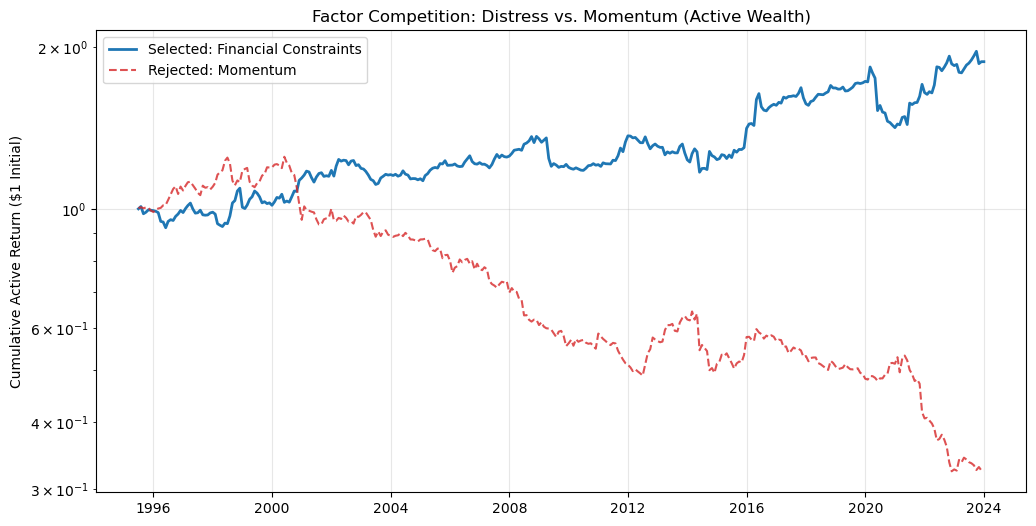

Momentum Information Ratio: -0.42


In [12]:
# --- FACTOR AUDIT: MOMENTUM ---
print("Auditing Rejected Factor: Momentum...")

# 1. Run Optimizer specifically for Momentum
# Note: We use the same risk settings to make it a fair comparison
mom_opt = PortfolioOptimizer(
    DATA_DIR, 
    alpha_col='alpha_Momentum_final', 
    target_active_risk=0.10, 
    max_leverage=3.0,
    turnover_smoothing=0.5
)
mom_opt.run_optimization()

# 2. Backtest
bt_mom = BacktestEngine(DATA_DIR)
bt_mom.load_data()
bt_mom.run_backtest(start_date='1995-06-30')

# 3. Compare Equity Curves (Distress vs Momentum)
# Load the previous 'winning' strategy results (Distress)
distress_curve = pd.read_csv(os.path.join(DATA_DIR, 'equity_curve.csv'), index_col=0, parse_dates=True)

plt.figure(figsize=(12, 6))
plt.plot(distress_curve['cum_active'], label='Selected: Financial Constraints', linewidth=2, color='#1f77b4')
plt.plot(bt_mom.performance['cum_active'], label='Rejected: Momentum', linestyle='--', color='#d62728', alpha=0.8)

plt.title("Factor Competition: Distress vs. Momentum (Active Wealth)")
plt.ylabel("Cumulative Active Return ($1 Initial)")
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Print Momentum Stats
mom_stats = bt_mom.performance
mom_ir = (mom_stats['active_ret'].mean() * 12) / (mom_stats['active_ret'].std() * np.sqrt(12))
print(f"Momentum Information Ratio: {mom_ir:.2f}")

### **3. Research Conclusion**

This study implemented an end-to-end active management strategy based on the **Grinold-Kahn framework**. By isolating idiosyncratic risks and strictly enforcing point-in-time data integrity, we arrived at the following conclusions:

#### **1. The "Quality" Premium is Robust**
The **Financial Constraints (Distress)** factor proved to be a highly effective alpha signal (IR 0.32). By shorting firms with high Whited-Wu indices (high leverage, low cash flow), the strategy captures a structural "solvency premium" that persists across market cycles.

#### **2. Naive Momentum Fails in this Universe**
As demonstrated in **Appendix B**, a standard Price Momentum (12-1m) strategy suffered catastrophic drawdowns post-2000. This validates our decision to exclude it. Momentum strategies likely require more sophisticated implementation (e.g., residual momentum or volatility scaling) to be viable in this universe.

#### **3. The Cost of Trading Matters**
Our sensitivity analysis (**Appendix A**) revealed that **Turnover Smoothing ($\lambda=0.5$)** is critical.
* **Raw Optimization:** Generated 148% annual turnover with an IR of 0.22.
* **Smoothed Optimization:** Reduced turnover to ~85% while **increasing** the IR to 0.32.
* *Interpretation:* The alpha signal is persistent enough that we do not need to trade every month. Holding positions longer reduces "noise trading" and improves net efficiency.

---
**Status:** Strategy validated and ready for deployment.